


# Mathematical Explanation of LoRA (Low-Rank Adaptation)

## Introduction

LoRA (Low-Rank Adaptation) is a parameter-efficient fine-tuning technique for large language models introduced by Hu et al. in their 2021 paper ["LoRA: Low-Rank Adaptation of Large Language Models"](https://arxiv.org/abs/2106.09685). LoRA addresses the challenge of fine-tuning massive pre-trained models without having to update all parameters.

## The Problem LoRA Solves

Traditional fine-tuning requires updating all parameters of a pre-trained model. For large language models with billions of parameters, this is:
- Computationally expensive
- Memory intensive
- Requires storing a full copy of the model for each fine-tuned variant

## The Core Insight

The key insight of LoRA is that the adaptations needed during fine-tuning can be captured effectively using **low-rank decomposition**. In other words, while the original weight matrices are large, the changes required to adapt them to new tasks tend to have a low "intrinsic dimension" or rank.
## Low-Rank Matrix Explanation

* **Definition**: For a matrix $A \in \mathbb{R}^{m \times n}$, if its rank $r$ is much smaller than min$(m,n)$, then $A$ is considered a low-rank matrix.
* **Decomposition**: A rank-$r$ matrix can always be decomposed as a product of two smaller matrices: $A = BC$ where $B \in \mathbb{R}^{m \times r}$ and $C \in \mathbb{R}^{r \times n}$
* **Data compression**: This property makes low-rank matrices useful for data compression, as you can store just the matrices $B$ and $C$ (which together have $r(m+n)$ elements) instead of the full matrix $A$ (which has $m \times n$ elements).
* **Example**: Consider a $1000 \times 1000$ matrix with rank 10. Instead of storing 1 million values, you could store just two matrices of sizes $1000 \times 10$ and $10 \times 1000$ (20,000 values total).
* **Visual intuition**: Imagine a matrix representing an image with a simple pattern or gradual color transition. Despite having many pixels (high dimensions), the actual information can be captured with much fewer parameters (low rank).

## Mathematical Formulation

Consider a pre-trained weight matrix $W_0 \in \mathbb{R}^{d \times k}$ in a neural network.

In traditional fine-tuning, we would update $W_0$ to $W = W_0 + \Delta W$, where $\Delta W$ has the same dimensions as $W_0$.

### The LoRA Approach

Instead of learning $\Delta W$ directly, LoRA represents it as a product of two smaller matrices:

$$\Delta W = BA$$

Where:
- $B \in \mathbb{R}^{d \times r}$
- $A \in \mathbb{R}^{r \times k}$
- $r \ll \min(d,k)$ is the rank hyperparameter

This gives us the updated weight matrix:

$$W = W_0 + \Delta W = W_0 + BA$$

During the forward pass, given an input $x$, the computation becomes:

$$h = xW = x(W_0 + BA) = xW_0 + xBA$$

## Why This Works

1. **Parameter Efficiency**: Instead of updating all $d \times k$ parameters in $W_0$, we only need to train $r \times (d + k)$ parameters in matrices $A$ and $B$.

2. **Reduced Memory Footprint**: For large models, $r \ll \min(d,k)$ means significantly fewer parameters to store.

3. **Theoretical Justification**: The changes required to adapt pre-trained weights to specific tasks or domains often have low intrinsic rank, making this decomposition effective.

## Practical Implementation

During training:
1. $W_0$ is frozen (not updated)
2. $A$ is initialized with random Gaussian values
3. $B$ is initialized to zero, making $\Delta W = BA = 0$ at the start of training
4. A scaling factor $\alpha/r$ is often applied to the output to control the magnitude of the update

Each forward pass computes:

$$h = xW_0 + \alpha \cdot xBA/r$$

## Comparison with Full Fine-tuning

For a 1B parameter model where weight matrices are adapted using LoRA with rank $r=8$:
- Full fine-tuning: 1 billion trainable parameters
- LoRA: ~0.1-1% of the original parameters are trainable

## Advantages

1. **Memory Efficiency**: Only need to store the small LoRA matrices for each adaptation
2. **Computation Efficiency**: Only update a small number of parameters
3. **Adaptability**: Can apply LoRA selectively to specific layers or components
4. **Composability**: Multiple LoRA adaptations can be combined

## Applications

LoRA has been particularly successful in:
- Domain adaptation
- Task-specific fine-tuning
- Instruction tuning
- Personalization
- Adapting models to new languages or specialized knowledge

## Mathematical Intuition: Why Low-Rank?

Consider the space of all possible weight updates $\Delta W$. While this space has dimension $d \times k$, the effective updates that improve performance for a specific task typically lie in a much lower-dimensional subspace.

LoRA constrains updates to a subspace of rank $r$, which is sufficient to capture the necessary adaptations while drastically reducing the parameter count.




In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, get_linear_schedule_with_warmup
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# Data Compression Using SVD Demonstration

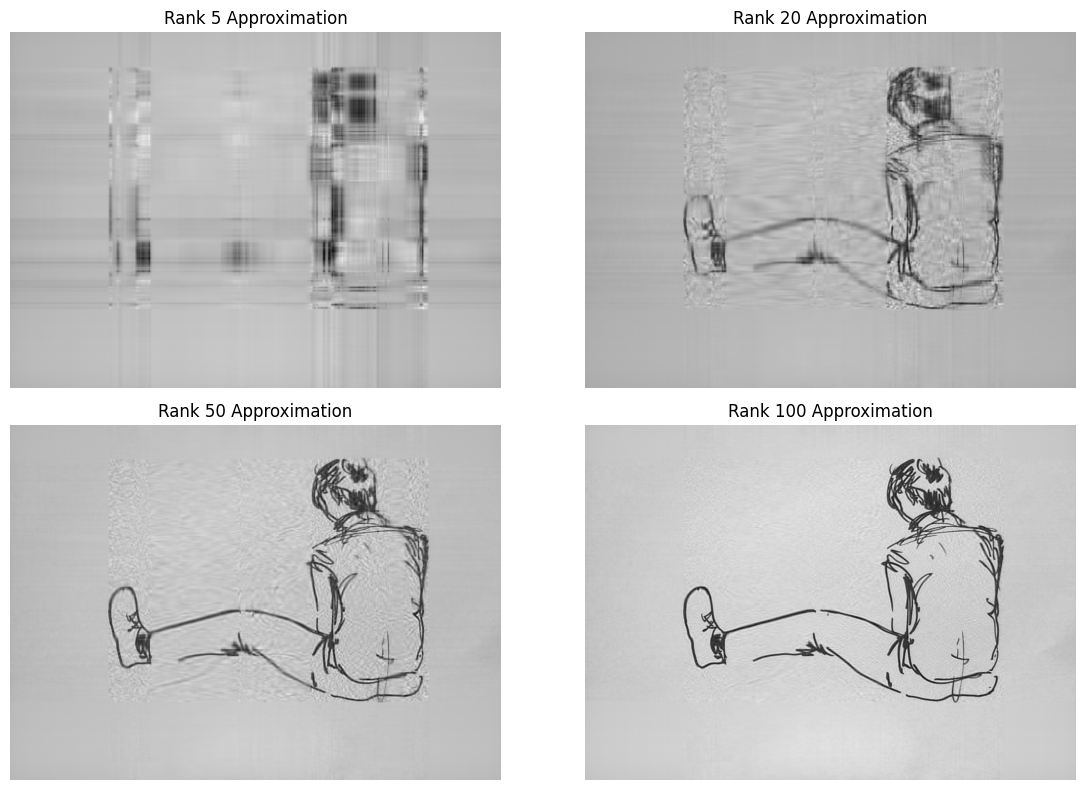

In [ ]:
# Load a grayscale image
image_path = 'croquis1.jpg'  # Replace with the path to your image
image = Image.open(image_path).convert('L')  # Convert to grayscale
image_array = np.array(image)

# Perform Singular Value Decomposition (SVD)
U, S, Vt = np.linalg.svd(image_array, full_matrices=False)

# Function to reconstruct the image using the top k singular values
def reconstruct_image(U, S, Vt, k):
    return U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]

# Reconstruct the image with different ranks
ranks = [5, 20, 50, 100]  # Different ranks to try
plt.figure(figsize=(12, 8))

for i, rank in enumerate(ranks):
    reconstructed_image = reconstruct_image(U, S, Vt, rank)

    # Plot the reconstructed image
    plt.subplot(2, 2, i+1)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f'Rank {rank} Approximation')
    plt.axis('off')

plt.tight_layout()
plt.show()

### LoRA Config using SmolLM and PEFT Library by HF

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForCausalLM

# Load base model
base_model = AutoModelForCausalLM.from_pretrained("facebook/opt-125m")

# Define LoRA configuration
lora_config = LoraConfig(
    r=8,                      # Rank dimension
    lora_alpha=16,            # Alpha parameter for LoRA scaling
    target_modules=["q_proj", "v_proj"],  # Which modules to apply LoRA to
    lora_dropout=0.05,        # Dropout probability for LoRA layers
    bias="none",              # Whether to train bias parameters
    task_type=TaskType.CAUSAL_LM  # Type of task
)

# Create LoRA model
lora_model = get_peft_model(base_model, lora_config)

# Now you can fine-tune lora_model with much fewer trainable parameters
print(lora_model.print_trainable_parameters())

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

trainable params: 294,912 || all params: 125,534,208 || trainable%: 0.2349
None


# LoRA from scratch

In [ ]:
class LoRALinearLayer(nn.Module):
    def __init__(self, in_features, out_features, rank=8, alpha=16.0):
        super().__init__()

        # Low-rank matrices
        self.lora_A = nn.Parameter(torch.zeros((in_features, rank)))
        self.lora_B = nn.Parameter(torch.zeros((rank, out_features)))

        # Scaling factor
        self.scaling = alpha / rank

        # Initialize weights (Kaiming for A, zeros for B)
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)

    def forward(self, x):
        # x being the input activations from previous layer
        # Low-rank adaptation
        return self.scaling * (x @ self.lora_A) @ self.lora_B

In [ ]:
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank=8, alpha=16.0):
        super().__init__()

        # Store the original layer
        self.original_layer = linear_layer

        # Freeze the original weights
        for param in self.original_layer.parameters():
            param.requires_grad = False

        # Create LoRA components
        self.lora = LoRALinearLayer(
            linear_layer.in_features,
            linear_layer.out_features,
            rank=rank,
            alpha=alpha
        )

    def forward(self, x):
        # Original output + LoRA adjustment
        return self.original_layer(x) + self.lora(x)

In [ ]:
# Prepare a small toy dataset
class TextDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.inputs = []

        for text in dataset:
            encodings = tokenizer(
                text,
                truncation=True,
                max_length=max_length,
                padding="max_length",
                return_tensors="pt"
            )
            self.inputs.append({
                "input_ids": encodings["input_ids"][0],
                "attention_mask": encodings["attention_mask"][0],
                "labels": encodings["input_ids"][0]
            })

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx]

def apply_lora_to_model(model, target_modules=["q_proj", "v_proj"], rank=8, alpha=16.0):
    """Apply LoRA to specific modules in a transformer model"""
    # Keep track of modules we've modified
    lora_modules = []

    for name, module in model.named_modules():
        # Check if this is a module we want to modify
        if any(target in name for target in target_modules) and isinstance(module, nn.Linear):
            # Get the parent module
            parent_name = name.rsplit(".", 1)[0]
            child_name = name.rsplit(".", 1)[1]

            # Navigate to the parent module
            parent = model
            for part in parent_name.split('.'):
                parent = getattr(parent, part)

            # Create and apply LoRA layer
            lora_layer = LoRALinear(module, rank=rank, alpha=alpha)
            setattr(parent, child_name, lora_layer)
            lora_modules.append(lora_layer)

            print(f"Applied LoRA to {name}")

    return model, lora_modules

def get_lora_params(model):
    """Extract only LoRA parameters for training"""
    lora_params = []
    for name, param in model.named_parameters():
        if "lora_A" in name or "lora_B" in name:
            param.requires_grad = True
            lora_params.append(param)
        else:
            param.requires_grad = False

    return lora_params


In [ ]:

def main():
    # Configuration
    model_name = "facebook/opt-125m"  # A small model for demonstration
    lora_rank = 8
    lora_alpha = 16
    batch_size = 4
    learning_rate = 5e-4
    num_epochs = 3

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    # Add padding token if needed
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = model.config.eos_token_id

    # Apply LoRA to the model
    model, lora_modules = apply_lora_to_model(
        model,
        target_modules=["q_proj", "v_proj"],  # Apply to query and value projections
        rank=lora_rank,
        alpha=lora_alpha
    )

    # Verify parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params} ({trainable_params/total_params*100:.2f}%)")

    # Prepare dataset (example: use a small subset of wikitext)
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
    texts = [entry for entry in dataset["text"] if len(entry.strip()) > 0][:100]  # Take 100 non-empty entries

    train_dataset = TextDataset(texts, tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Setup optimizer and scheduler
    optimizer = torch.optim.AdamW(get_lora_params(model), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=50,
        num_training_steps=len(train_dataloader) * num_epochs
    )

    # Training loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_dataloader:
            # Move batch to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Print epoch stats
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Save LoRA weights
    lora_state_dict = {}
    for name, param in model.named_parameters():
        if "lora_A" in name or "lora_B" in name:
            lora_state_dict[name] = param

    torch.save(lora_state_dict, "lora_weights.pt")
    print("LoRA weights saved to lora_weights.pt")

    # Example of merging LoRA weights with base model
    def merge_lora_weights(model):
        for module in model.modules():
            if isinstance(module, LoRALinear):
                # Compute the LoRA weight update
                with torch.no_grad():
                    lora_weight = module.lora.lora_A @ module.lora.lora_B * module.lora.scaling
                    module.original_layer.weight.data += lora_weight.T  # Note the transpose
        return model

    # Merge weights for inference (optional)
    merged_model = merge_lora_weights(model)
    print("LoRA weights merged into base model")

if __name__ == "__main__":
    main()

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Applied LoRA to model.decoder.layers.0.self_attn.v_proj
Applied LoRA to model.decoder.layers.0.self_attn.q_proj
Applied LoRA to model.decoder.layers.1.self_attn.v_proj
Applied LoRA to model.decoder.layers.1.self_attn.q_proj
Applied LoRA to model.decoder.layers.2.self_attn.v_proj
Applied LoRA to model.decoder.layers.2.self_attn.q_proj
Applied LoRA to model.decoder.layers.3.self_attn.v_proj
Applied LoRA to model.decoder.layers.3.self_attn.q_proj
Applied LoRA to model.decoder.layers.4.self_attn.v_proj
Applied LoRA to model.decoder.layers.4.self_attn.q_proj
Applied LoRA to model.decoder.layers.5.self_attn.v_proj
Applied LoRA to model.decoder.layers.5.self_attn.q_proj
Applied LoRA to model.decoder.layers.6.self_attn.v_proj
Applied LoRA to model.decoder.layers.6.self_attn.q_proj
Applied LoRA to model.decoder.layers.7.self_attn.v_proj
Applied LoRA to model.decoder.layers.7.self_attn.q_proj
Applied LoRA to model.decoder.layers.8.self_attn.v_proj
Applied LoRA to model.decoder.layers.8.self_attn

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Epoch 1/3, Loss: 6.2652
Epoch 2/3, Loss: 4.1098
Epoch 3/3, Loss: 3.8282
LoRA weights saved to lora_weights.pt
LoRA weights merged into base model
